# MCMC fitting
In this notebook, I will read in the RV data and perform the MCMC fit to find the mass-ratio.

[for now, I am writing up how to do an SB2 fit. If that fails again, I will fall back to a partial fit using Stefano's parameters.]

In [1]:
import numpy as np
import pandas as pd
import MassRatio_Fitter
import triangle
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# Read in the austral rv fits
rv1_data = pd.read_fwf('data/psi1draa_140p_28_37_ASW.dat', header=None)
t1 = rv1_data[0].values
rv1 = rv1_data[2].values / 1000. # Convert from m/s to km/s
rv1_err = rv1_data[3].values / 1000.

# Read in my measurements for the companion RV
t2, _, _, rv2, rv2_err = np.loadtxt('data/rv_data.txt')
good = (~np.isnan(rv2)) & (t2 > t2[20])  #Exclude the early points that I don't trust, and the couple others that have no measurements
t2 = t2[good]
rv2 = rv2[good]
rv2_err = rv2_err[good]

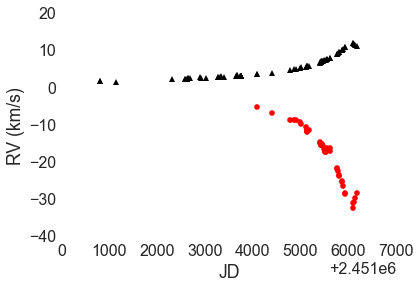

In [8]:
# Plot the RV data just to make sure it looks right
plt.errorbar(t1, rv1, yerr=rv1_err, fmt='k^')
plt.errorbar(t2, rv2, yerr=rv2_err*0.1, fmt='ro')
plt.xlabel('JD')
plt.ylabel('RV (km/s)')

In [9]:
# Do the fit
reload(M)
sampler = MassRatio_Fitter.full_sb2_fit(t1, rv1, rv1_err, t2, rv2, rv2_err)

Done with burn-in iteration 000
Done with burn-in iteration 010
Done with burn-in iteration 020
Done with burn-in iteration 030
Done with burn-in iteration 040
Done with burn-in iteration 050
Done with burn-in iteration 060
Done with burn-in iteration 070
Done with burn-in iteration 080
Done with burn-in iteration 090
Done with burn-in iteration 100
Done with burn-in iteration 110
Done with burn-in iteration 120
Done with burn-in iteration 130
Done with burn-in iteration 140
Done with burn-in iteration 150
Done with burn-in iteration 160
Done with burn-in iteration 170
Done with burn-in iteration 180
Done with burn-in iteration 190
Done with burn-in iteration 200
Done with burn-in iteration 210
Done with burn-in iteration 220
Done with burn-in iteration 230
Done with burn-in iteration 240
Done with burn-in iteration 250
Done with burn-in iteration 260
Done with burn-in iteration 270
Done with burn-in iteration 280
Done with burn-in iteration 290
Done with burn-in iteration 300
Done wit

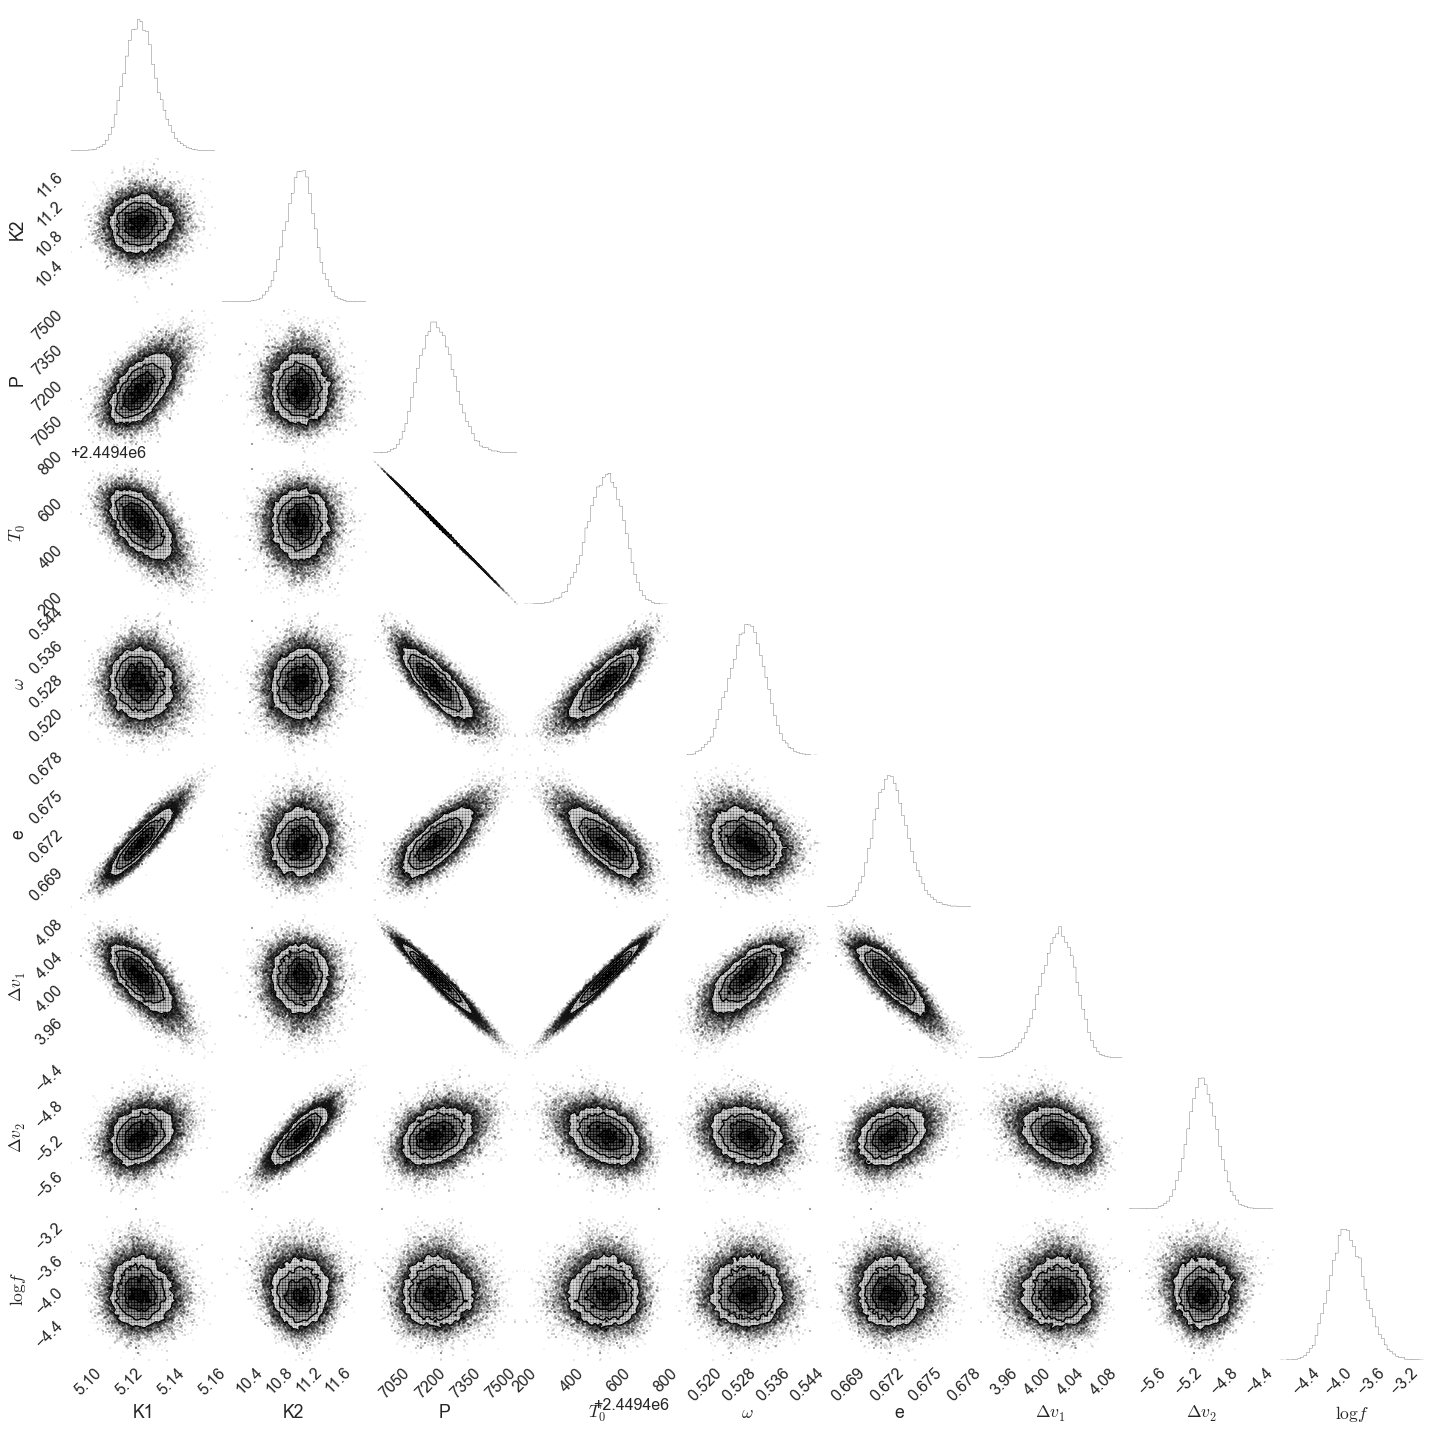

In [24]:
# Visualize with an "everything vs everything" plot
samples = sampler.chain[:, 500:, :].reshape((-1, sampler.chain.shape[-1]))
triangle.corner(samples, labels=['K1', 'K2', 'P', '$T_0$', '$\omega$', 'e', '$\Delta v_1$', '$\Delta v_2$', '$\log{f}$'])
plt.savefig('../Paper/Figures/SB2_Corner.pdf')

q = 0.463 +0.009 / -0.008


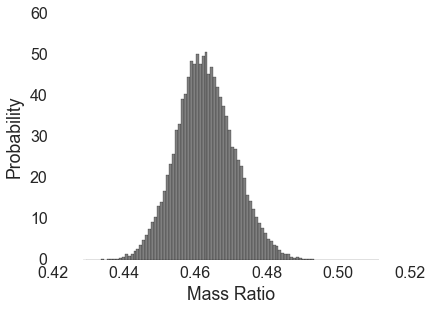

In [32]:
# Measure the mass-ratio
K1 = samples[:, 0]
K2 = samples[:, 1]
q = K1 / K2
out = plt.hist(q, bins=100, color='gray', normed=True)
plt.xlabel('Mass Ratio')
plt.ylabel('Probability')

l, m, h = np.percentile(q, [16, 50, 84])
print('q = {:.3f} +{:.3f} / -{:.3f}'.format(m, h-m, m-l))
plt.savefig('../Paper/Figures/MassRatio.pdf')

In [34]:
# Determine the value of each parameter
def print_val(label, samp, fmt='{:s} = {:.3f} + {:.3f} / - {:.3f}'):
    l, m, h = np.percentile(samp, [16, 50, 84])
    s = fmt.format(label, m, h-m, m-l)
    print(s)
    return s

variables = ['K1', 'K2', 'Period', 'T0', 'w', 'e', 'dv1', 'dv2', 'lnf']
for i, var_name in enumerate(variables):
    if var_name == 'w':
        s = print_val(var_name, samples[:, i]*180/np.pi)
    elif var_name == 'lnf':
        s = print_val('f', np.exp(samples[:, i]/2.0))
    else:
        s = print_val(var_name, samples[:, i])
    

K1 = 5.125 + 0.008 / - 0.007
K2 = 11.081 + 0.186 / - 0.201
Period = 7225.354 + 79.345 / - 73.205
T0 = 2449943.477 + 73.270 / - 79.325
w = 30.357 + 0.241 / - 0.252
e = 0.672 + 0.001 / - 0.001
dv1 = 4.026 + 0.020 / - 0.022
dv2 = -5.042 + 0.166 / - 0.161
f = 0.143 + 0.017 / - 0.014


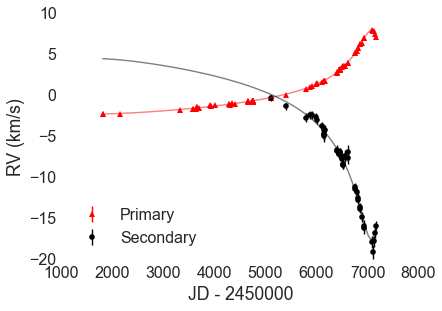

In [31]:
# Make a plot of the best-fit solution (the median of the posterior distribution)
best_pars = np.median(samples, axis=0)
fig, axes = MassRatio_Fitter.plot(best_pars, t1, rv1, rv1_err, t2, rv2, rv2_err, resids=False)
plt.savefig('../Paper/Figures/SB2_Orbit.pdf')

In [35]:
# Save the MCMC samples
np.save('data/SB2_samples.npy', samples)